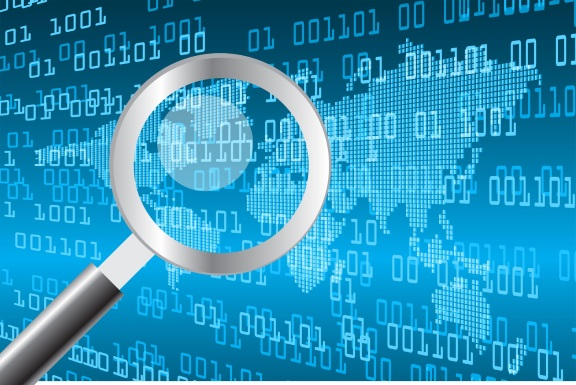

## Introduction
* Using the info set from: https://u.cs.biu.ac.il/~koppel/BlogCorpus.htm you shall build an enquiry and ranking system for taking a question as input and retrieving all the blogs that contain the terms and also are ranked.
* The query are provided as an English query joined does on google search.
* The query could contain sentence/keyword/phrases query.
* Do confine mind, the queries may not contain the precise words as presented within the blogs, so please make sure that relevant words and similar word matches are taken into consideration.
1. Data Cleaning and Pre-processing.
2. Using BERT to embedded paragraphs of papers using bert-base-nli-mean-tokens pretrained model.
3. Find the closest 5 sentences of the corpus for every query sentence supported cosine similarity.



## Semantic Search

At first, search engines were lexical: the search engine looked for literal matches of the query words, without understanding of the query’s meaning and only returning links that contained the exact query.By using regular keyword search, a document either contains the given word or not, and there is no middle ground

On the other hand, "Semantic Search" can simplify query building, becuase it is supported by automated natural language processing programs i.e. using Latent Semantic Indexing - a concept that search engines use to discover how a keyword and content work together to mean the same thing.



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import spacy
import string
import gensim
import operator
import re

### Load the data
We will now load the movies data csv into dataframe and quickly peek into the columns and data provided

In [2]:
df_blog = pd.read_csv('/kaggle/input/blog-authorship-corpus/blogtext.csv')
df_blog.head()

id gender  age              topic      sign          date  \
0  2059027   male   15            Student       Leo   14,May,2004   
1  2059027   male   15            Student       Leo   13,May,2004   
2  2059027   male   15            Student       Leo   12,May,2004   
3  2059027   male   15            Student       Leo   12,May,2004   
4  3581210   male   33  InvestmentBanking  Aquarius  11,June,2004   

                                                text  
0             Info has been found (+/- 100 pages,...  
1             These are the team members:   Drewe...  
2             In het kader van kernfusie op aarde...  
3                   testing!!!  testing!!!            
4               Thanks to Yahoo!'s Toolbar I can ...

### Data Cleaning and Pre-processing
In this step, we try to remove any unwanted words or characters which are written for human readability, but won't contribute to topic modelling in anyway.

The following function applies regular expression for matching patterns of unwanted text and removing/replacing them.


In [3]:

import pandas as pd
from tqdm import tqdm


#function for data cleaning and processing
def spacy_tokenizer(sentence):
 
    #remove distracting single quotes
    sentence = re.sub('\'','',sentence)

    #remove digits adnd words containing digits
    sentence = re.sub('\w*\d\w*','',sentence)

    #replace extra spaces with single space
    sentence = re.sub(' +',' ',sentence)

    #remove unwanted lines starting from special charcters
    sentence = re.sub(r'\n: \'\'.*','',sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)
    
    #remove non-breaking new line characters
    sentence = re.sub(r'\n',' ',sentence)
    
    #remove punctunations
    sentence = re.sub(r'[^\w\s]',' ',sentence)

    return sentence


Now let us apply the data-cleaning and pre-processing function to our movies "wiki_plot" column and store the cleaned, tokenized data into new column

In [4]:
print ('Cleaning and Pre-processing...')


%time df_blog['Pre_processing'] = df_blog['text'].map(lambda x: spacy_tokenizer(x))


Cleaning and Pre-processing...
CPU times: user 4min 19s, sys: 1.51 s, total: 4min 20s
Wall time: 4min 25s


Store the tokenized column into a sepearte variable for ease of operations in subsequent sections and have a quick peek into the values

In [5]:
df_sentences = df_blog["Pre_processing"].to_dict()
df_sentences = list(df_sentences.keys())


df_sentences_list = [str(d) for d in tqdm(df_sentences)]

100%|██████████| 681284/681284 [00:00<00:00, 1580393.26it/s]


In [6]:
!pip install git+https://github.com/UKPLab/sentence-transformers.git


  Cloning https://github.com/UKPLab/sentence-transformers.git to /tmp/pip-req-build-dse1wik5
  Running command git clone -q https://github.com/UKPLab/sentence-transformers.git /tmp/pip-req-build-dse1wik5
  Created wheel for sentence-transformers: filename=sentence_transformers-1.0.4-py3-none-any.whl size=123431 sha256=dfcaa6d21480f91134265c07e11cca9bd4cb65e723269efa237dc55e4a4868da
  Stored in directory: /tmp/pip-ephem-wheel-cache-3f5dqhc7/wheels/d2/fe/ee/ad3e2d10548814ec0b550863ae9746bde8e30c0c6a7855441c
Successfully built sentence-transformers


In [7]:
#https://github.com/UKPLab/sentence-transformers/blob/master/examples/application_semantic_search.py
"""
This script outputs for various queries the top 5 most similar sentences in the corpus.
"""

from sentence_transformers import SentenceTransformer
import scipy.spatial
import pickle as pkl
# we use BERT to embedded paragraphs of papers using bert-base-nli-mean-tokens pretrained mode
embedder = SentenceTransformer('bert-base-nli-mean-tokens')

# Corpus with example sentences
corpus = df_sentences_list
corpus_embeddings = embedder.encode(corpus,show_progress_bar=True)
with open("./blog_finetuned_embeddings.pkl" , "wb") as f:
    pkl.dump(corpus_embeddings,f)
    
# with open("./blog_finetuned_embeddings.pkl" , "rb") as file_:
#     corpus_embeddings = pkl.load(file_)

# Query sentences:
queries = ['I did what I was instructed ages back',
           'Knowledge of the frequency,cardiomyopathy and cardiac arrest',
           'Use of AI in done manually',
           'Resources to care facilities.',
           'Mobilization  communities .',
           'Age-adjusted – particularly for viral etiologies .']
query_embeddings = embedder.encode(queries,show_progress_bar=True)

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
closest_n = 5
print("\nTop 5 most similar sentences in corpus:")
movie_names = []

for query, query_embedding in zip(queries, query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

    print("\n\n=========================================================")
    print("==========================Query==============================")
    print("===",query,"=====")
    print("=========================================================")


    for idx, distance in results[0:closest_n]:
        pass
        print("Score:   ", "(Score: %.4f)" % (1-distance) , "\n" )
        print("Paragraph:   ", corpus[idx].strip(), "\n" )
        index =corpus[idx]
        print(idx)
        row_dict = df_blog.loc[df_blog.index== idx].to_dict()
        print("id:  " , row_dict["id"][idx] , "\n")
        print("Title:  " , row_dict["topic"][idx] , "\n")
        print("text:  " , row_dict["text"][idx] , "\n")
        print("-------------------------------------------")

  0%|          | 0.00/405M [00:00<?, ?B/s]

Batches:   0%|          | 0/21291 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Top 5 most similar sentences in corpus:


==========================Query==============================
=== I did what I was instructed ages back =====
Score:    (Score: 0.5687) 

Paragraph:    135191 

135191
id:   1057539 

Title:   Telecommunications 

text:                Eeek! Yucky day here in the Big Apple. The buildings have all but disappeared across the street due to the fog. Everyone around me seems to be in a funky mood, including me. And it seems to be affecting my typing abilities. I could use a massage for sure. Chris & Sergio went out again last night for what has become their weekly ritual. They didn't get home until 5:30 am so I can only guess that they had a good time. Since I always have to work the next morning, I'm never invited to these little soirées. Oh, well. Don't cry over spilled milk, right?  I had the strangest dream last night. I was at a restaurant going up a set of stairs meant for the waitstaff (cause the elevator was broken) but on my way up, I chang